In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from fastai.vision import *
from fastai import * 
from fastai.text import *
from pathlib import Path 
from tqdm import tqdm
tqdm.pandas(desc="my bar!")

In [3]:
import torchtext
from torchtext.data import Iterator, BucketIterator
from torchvision import transforms, utils
from sklearn.metrics import confusion_matrix, f1_score, auc, roc_curve, precision_recall_curve

In [4]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

# Language Model

In [5]:
lm = True
clean = False

In [6]:
if lm: path = Path('../input'); 
list(path.iterdir())

[WindowsPath('../input/embeddings'),
 WindowsPath('../input/glove.840B.300d'),
 WindowsPath('../input/sample_submission.csv'),
 WindowsPath('../input/test.csv'),
 WindowsPath('../input/tmp_lm'),
 WindowsPath('../input/train.csv')]

train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
allText_df = train_df.copy().append(test_df.copy(), sort=False)

In [7]:
if clean:
    train_df["question_text"] = train_df["question_text"].apply(lambda x: x.lower())
    test_df["question_text"] = test_df["question_text"].apply(lambda x: x.lower())
    allText_df["question_text"] = allText_df["question_text"].apply(lambda x: x.lower())

    train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_text(x))
    test_df['question_text'] = test_df['question_text'].apply(lambda x: clean_text(x))
    allText_df["question_text"] = allText_df["question_text"].apply(lambda x: clean_text(x))

    train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_numbers(x))
    test_df['question_text'] = test_df['question_text'].apply(lambda x:clean_numbers(x))
    allText_df["question_text"] = allText_df["question_text"].apply(lambda x: clean_numbers(x))

    train_df['question_text'] = train_df['question_text'].apply(lambda x: replace_typical_mispell(x))
    test_df['question_text'] = test_df['question_text'].apply(lambda x: replace_typical_mispell(x))
    allText_df["question_text"] = allText_df["question_text"].apply(lambda x: replace_typical_misspell(x))

#train_x = train_df['question_text'].fillna('_##_').values
#test_x = test_df['question_text'].fillna('_##_').values

import zipfile
zf = zipfile.ZipFile(path/'test.csv.zip')
df_test = pd.read_csv(zf.open('test.csv'))
zf = zipfile.ZipFile(path/'train.csv.zip')
df_train = pd.read_csv(zf.open('train.csv'))



In [8]:
#print(df_train.head(3))

print(train_df.shape)
print(test_df.shape)

In [9]:
# df_train.head(3)

In [10]:
def prepare_sequences():
    tokenizer = lambda text: text.split() # the function above is the function we will be using to tokenize the text
    TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer, lower=True)
    LABEL = torchtext.data.Field(sequential=False, use_vocab=False) # sequential and use_vocab=False since no text (binary)
    train_datafields = [("qid", None), ("question_text", TEXT), ("target", LABEL)]
    train = torchtext.data.TabularDataset( # If we had a validation set as well, we would add an additional .splits(...)
                        # path="data/train_cleaned_v2.csv", # the root directory where the data lies
                        path = path/'train.csv',
                        format='csv',
                        # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
                        skip_header=True, 
                        fields=train_datafields)
    test_datafields = [("qid", None),
                     ("question_text", TEXT)] 
    test = torchtext.data.TabularDataset( 
                path=path/'test.csv',
                format="csv",
                skip_header=True,
                fields=test_datafields)
    return TEXT, LABEL, train, test
# Chat Conversation End
# Type a message...



In [11]:
TEXT,LABEL,train,test = prepare_sequences()


LABEL.batch_first


In [12]:
TEXT.build_vocab(train, test, vectors = "glove.6B.50d")

In [13]:
train_storage = train

In [14]:
train,_ = train.split(0.05)

In [15]:
from torchtext.data import Iterator, BucketIterator
train_iter = BucketIterator(
    train, # we pass in the datasets we want the iterator to draw data from
    batch_size= 64, 
    sort_key= lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False, # sorting would add bias
    repeat=False)

test_iter = Iterator(
    test,
    batch_size = 64,
    sort = False,
    sort_within_batch = False,
    repeat = False)

ngpu = 0
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [16]:
#iter(train_iter).__next__().question_text
len(train_iter)
label_Size = next(iter(train_iter)).target
len(label_Size[label_Size==1])
#train_iter.batches
#train_iter = iter(train_iter)
#train_iter.__next__().question_text
#train_iter.__next__().target
#iter(train_iter).__next__().question_text.shape

4

In [17]:
#smaller,_ = train.split(0.1)

In [18]:
#smaller.examples[0].question_text

In [19]:
#len(train)
len(test_iter)

5872

In [20]:
#train.examples[0].question_text

In [21]:
TEXT.vocab.vectors.shape

torch.Size([527626, 50])

TEXT.vocab.freqs

In [22]:
embed_size = 50
hidden_size = 150
ver1 = True
bidir = False
layer_LSTM = 1
layer_Lin = 2
dropout_LSTM = 0.1
dropout_Lin = 0.1

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet,self).__init__()
        
        hidden_size = 64
        
        self.embedding = nn.Embedding(len(TEXT.vocab),embed_size)
        self.embedding.weight = nn.Parameter(TEXT.vocab.vectors)
        self.embedding_dropout = nn.Dropout2d(0.1)
        
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        
        self.linear = nn.Linear(hidden_size*4,2)
        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(16,1)
        
    def forward(self,train):
        #print(train.shape)
        h_embedding = self.embedding(train)
        #print(h_embedding.shape)
        h_embedding = torch.squeeze(self.embedding_dropout(torch.unsqueeze(h_embedding,0)))
        #print(h_embedding.shape)
        
        h_lstm, _ = self.lstm(h_embedding)
        #print(h_lstm.shape)
        h_gru, _ = self.gru(h_lstm)
        #print(h_gru.shape)
        
        avg_pool = torch.mean(h_gru,1)
        #print(avg_pool.shape)
        #avg_pool = avg_pool.view(-1,64)
        max_pool, _ = torch.max(h_gru,1)
        #print(max_pool.shape)
        
        
        conc = torch.cat((avg_pool, max_pool),1)
        print(conc.shape)
        conc = self.relu(self.linear(conc))
        #print(conc.shape)
        #conc = self.dropout(conc)
        print(conc.shape)
        #out = nn.Sigmoid()(conc)
        
        out = nn.LogSoftmax(dim=1)(conc)
        
        #out = self.out(conc)
        #print(out[:,-1].shape)
        
        return out
    
    
    
    
batch = next(iter(train_iter)).question_text
net = NeuralNet()
#net(batch)

In [23]:
#batch = next(iter(train_iter)).question_text
#batch[30]
#layer_Lin

In [24]:
class LSTMTagger(nn.Module):
    def __init__(self):
        super(LSTMTagger, self).__init__()
                      
        self.hidden_dim = hidden_size
        
        self.embedding = nn.Embedding(len(TEXT.vocab),embed_size)
        self.embedding.weight = nn.Parameter(TEXT.vocab.vectors)
        
        
        #self.embedding_dropout = nn.Dropout2d(0.1)
        
        self.lstm_Layer = nn.LSTM(embed_size, hidden_size,num_layers = layer_LSTM, dropout = dropout_LSTM, bidirectional = bidir)
        
        self.lin_Layer = []
        
        self.lin_Layer_Dropout = dropout_Lin
        
        if bidir:
            scale = 2
        else:
            scale = 1
        
        for _ in range(layer_Lin - 1):
            self.lin_Layer.append(nn.Linear(hidden_size*scale,hidden_size*scale))
            self.lin_Layer = nn.ModuleList(self.lin_Layer)
                
        self.hidden2tag = nn.Linear(hidden_size*scale, 2)
    
    def forward(self, train):
        #print(train.shape)
        embeds = self.embedding(train)
        #print(embeds.shape)
        #print(embeds.view(len(train),64,-1).shape)
        #print(embeds.view(len(train),train.shape[1],-1).shape)
        lstm_out, _ = self.lstm_Layer(embeds)#embeds.view(len(train),train.shape[1],-1))
        #print(lstm_out.shape)
        
        if ver1:
            #print(lstm_out.shape)
            feature = lstm_out[-1,:,:] # -1 grabs last layer in list
            #print(feature.shape)
        
            for layer in self.lin_Layer:
                feature = layer(feature)
                feature = F.relu(feature)
                predict = self.hidden2tag(feature)
        
            feature = F.relu(feature)
            predict = self.hidden2tag(feature)
            return nn.LogSoftmax(dim=1)(predict)
        else:
           
            avg_pool = torch.mean(lstm_out,0)
            #print(avg_pool.shape)
            target_space = self.hidden2tag(avg_pool)#.view(len(train),-1))
            #print(target_space.shape)
            target_score = F.log_softmax(target_space, dim=1)
            #print(target_score.shape)
            return target_score

inputs_check = next(iter(train_iter)).question_text

#print(inputs_check.shape)

model = LSTMTagger()

with torch.no_grad():
    inputs = inputs_check
    #print(len(inputs))
    score = model(inputs)
    #print(score.shape)

C:\Users\xw5735\PWinFolder\WPy-3661\python-3.6.6.amd64\lib\site-packages\torch\nn\modules\rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [25]:
model = LSTMTagger()
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr=0.2, momentum=0.9)

C:\Users\xw5735\PWinFolder\WPy-3661\python-3.6.6.amd64\lib\site-packages\torch\nn\modules\rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [26]:
validate = True

checking = next(iter(train_iter))
inputs_check = checking.question_text
target_check = checking.target


f1_train = []
auc_train = []

avg_loss = 0

with torch.no_grad():
    inputs = inputs_check
    score1 = model(inputs)
    #print(score)
    
for epoch in range(2):
    model.train()
    avg_loss = 0
    model.zero_grad()
    all_preds = []
    all_actual = []
    for batch_num in range(len(train_iter)):
        optimizer.zero_grad()
        
        sentence_data = next(iter(train_iter))
        sentence_in = sentence_data.question_text
        targets = sentence_data.target
        
        target_scores = model(sentence_in)
        
        all_preds.extend(target_scores.tolist())#torch.round(target_scores).tolist())
        all_actual.extend(targets.tolist())
        
        #print(np.asarray(target_scores)[:,1].max())
        
        loss = loss_function(target_scores, targets)
        avg_loss += loss.item()
        
        #print(loss)
        print(batch_num+1,"out of: ",len(train_iter), " With Loss of: ",loss, " Best Score of: ", np.asarray(target_scores)[:,1].max())
        loss.backward()
        optimizer.step()
    
    #model.eval()
    avg_loss = avg_loss/len(train_iter)
    
    #if validate:
        #avg_val
    
    
    #else:
    print("Training loss for epoch {} is {}".format(epoch + 1, avg_loss))
    
    
    #train_confusion_matrix = confusion_matrix(all_actual, all_preds).ravel()
    
    pred_Clas = (np.asarray(all_preds)[:,1] > np.asarray(all_preds)[:,0]).astype(int)#-2.65).astype(int)#
    train_confusion_matrix = confusion_matrix(all_actual, pred_Clas).ravel()
    
    print("Confusion matrix for epoch {}, tn={}, fp={}, fn={}, tp={}".format(epoch + 1, *train_confusion_matrix))
    f1_train.append(f1_score(all_actual, pred_Clas))
    print("F1 score for epoch {} is {}".format(epoch + 1, f1_train[-1]))
    fpr, tpr, _ = roc_curve(all_actual, pred_Clas, pos_label=1)
    auc_train.append(auc(fpr, tpr))
    print("AUC for epoch {} is {}\n".format(epoch + 1, auc_train[-1]))

with torch.no_grad():
    inputs = inputs_check
    score2 = model(inputs)
    #print(score)
        
        

1 out of:  1021  With Loss of:  tensor(0.6899, grad_fn=<NllLossBackward>)  Best Score of:  -0.6968408
2 out of:  1021  With Loss of:  tensor(0.5840, grad_fn=<NllLossBackward>)  Best Score of:  -0.82027096
3 out of:  1021  With Loss of:  tensor(0.4300, grad_fn=<NllLossBackward>)  Best Score of:  -1.0922033
4 out of:  1021  With Loss of:  tensor(0.3076, grad_fn=<NllLossBackward>)  Best Score of:  -1.5142808
5 out of:  1021  With Loss of:  tensor(0.2865, grad_fn=<NllLossBackward>)  Best Score of:  -2.0628467
6 out of:  1021  With Loss of:  tensor(0.1936, grad_fn=<NllLossBackward>)  Best Score of:  -2.6653876
7 out of:  1021  With Loss of:  tensor(0.1904, grad_fn=<NllLossBackward>)  Best Score of:  -3.293993
8 out of:  1021  With Loss of:  tensor(0.3230, grad_fn=<NllLossBackward>)  Best Score of:  -3.8914542
9 out of:  1021  With Loss of:  tensor(0.2171, grad_fn=<NllLossBackward>)  Best Score of:  -4.3726506
10 out of:  1021  With Loss of:  tensor(0.6027, grad_fn=<NllLossBackward>)  Best S

80 out of:  1021  With Loss of:  tensor(0.2794, grad_fn=<NllLossBackward>)  Best Score of:  -2.9202619
81 out of:  1021  With Loss of:  tensor(0.2348, grad_fn=<NllLossBackward>)  Best Score of:  -2.9310033
82 out of:  1021  With Loss of:  tensor(0.4171, grad_fn=<NllLossBackward>)  Best Score of:  -2.9642906
83 out of:  1021  With Loss of:  tensor(0.0989, grad_fn=<NllLossBackward>)  Best Score of:  -2.9326298
84 out of:  1021  With Loss of:  tensor(0.2346, grad_fn=<NllLossBackward>)  Best Score of:  -2.9385712
85 out of:  1021  With Loss of:  tensor(0.2801, grad_fn=<NllLossBackward>)  Best Score of:  -2.9375901
86 out of:  1021  With Loss of:  tensor(0.0995, grad_fn=<NllLossBackward>)  Best Score of:  -2.9216197
87 out of:  1021  With Loss of:  tensor(0.1895, grad_fn=<NllLossBackward>)  Best Score of:  -2.9144526
88 out of:  1021  With Loss of:  tensor(0.2800, grad_fn=<NllLossBackward>)  Best Score of:  -2.9294028
89 out of:  1021  With Loss of:  tensor(0.1892, grad_fn=<NllLossBackward>

159 out of:  1021  With Loss of:  tensor(0.4381, grad_fn=<NllLossBackward>)  Best Score of:  -2.6414971
160 out of:  1021  With Loss of:  tensor(0.1124, grad_fn=<NllLossBackward>)  Best Score of:  -2.6129632
161 out of:  1021  With Loss of:  tensor(0.2740, grad_fn=<NllLossBackward>)  Best Score of:  -2.619731
162 out of:  1021  With Loss of:  tensor(0.3153, grad_fn=<NllLossBackward>)  Best Score of:  -2.6240602
163 out of:  1021  With Loss of:  tensor(0.3144, grad_fn=<NllLossBackward>)  Best Score of:  -2.5928035
164 out of:  1021  With Loss of:  tensor(0.3943, grad_fn=<NllLossBackward>)  Best Score of:  -2.5832663
165 out of:  1021  With Loss of:  tensor(0.3530, grad_fn=<NllLossBackward>)  Best Score of:  -2.5444386
166 out of:  1021  With Loss of:  tensor(0.3125, grad_fn=<NllLossBackward>)  Best Score of:  -2.4812412
167 out of:  1021  With Loss of:  tensor(0.1609, grad_fn=<NllLossBackward>)  Best Score of:  -2.4559748
168 out of:  1021  With Loss of:  tensor(0.2746, grad_fn=<NllLoss

238 out of:  1021  With Loss of:  tensor(0.2733, grad_fn=<NllLossBackward>)  Best Score of:  -2.353106
239 out of:  1021  With Loss of:  tensor(0.1503, grad_fn=<NllLossBackward>)  Best Score of:  -2.3583775
240 out of:  1021  With Loss of:  tensor(0.1939, grad_fn=<NllLossBackward>)  Best Score of:  -2.4141562
241 out of:  1021  With Loss of:  tensor(0.2761, grad_fn=<NllLossBackward>)  Best Score of:  -2.4232476
242 out of:  1021  With Loss of:  tensor(0.3183, grad_fn=<NllLossBackward>)  Best Score of:  -2.4900103
243 out of:  1021  With Loss of:  tensor(0.2732, grad_fn=<NllLossBackward>)  Best Score of:  -2.5848212
244 out of:  1021  With Loss of:  tensor(0.2764, grad_fn=<NllLossBackward>)  Best Score of:  -2.5079556
245 out of:  1021  With Loss of:  tensor(0.1912, grad_fn=<NllLossBackward>)  Best Score of:  -2.7346268
246 out of:  1021  With Loss of:  tensor(0.2771, grad_fn=<NllLossBackward>)  Best Score of:  -2.5223856
247 out of:  1021  With Loss of:  tensor(0.2717, grad_fn=<NllLoss

316 out of:  1021  With Loss of:  tensor(0.2365, grad_fn=<NllLossBackward>)  Best Score of:  -1.8149763
317 out of:  1021  With Loss of:  tensor(0.3714, grad_fn=<NllLossBackward>)  Best Score of:  -1.8681521
318 out of:  1021  With Loss of:  tensor(0.4892, grad_fn=<NllLossBackward>)  Best Score of:  -2.098693
319 out of:  1021  With Loss of:  tensor(0.2355, grad_fn=<NllLossBackward>)  Best Score of:  -1.9248548
320 out of:  1021  With Loss of:  tensor(0.2296, grad_fn=<NllLossBackward>)  Best Score of:  -1.7084397
321 out of:  1021  With Loss of:  tensor(0.3404, grad_fn=<NllLossBackward>)  Best Score of:  -1.5585041
322 out of:  1021  With Loss of:  tensor(0.1792, grad_fn=<NllLossBackward>)  Best Score of:  -1.6060386
323 out of:  1021  With Loss of:  tensor(0.2378, grad_fn=<NllLossBackward>)  Best Score of:  -1.4816556
324 out of:  1021  With Loss of:  tensor(0.2771, grad_fn=<NllLossBackward>)  Best Score of:  -1.3020949
325 out of:  1021  With Loss of:  tensor(0.1259, grad_fn=<NllLoss

394 out of:  1021  With Loss of:  tensor(0.1856, grad_fn=<NllLossBackward>)  Best Score of:  -2.0410118
395 out of:  1021  With Loss of:  tensor(0.1495, grad_fn=<NllLossBackward>)  Best Score of:  -1.8787149
396 out of:  1021  With Loss of:  tensor(0.3210, grad_fn=<NllLossBackward>)  Best Score of:  -1.9629225
397 out of:  1021  With Loss of:  tensor(0.1955, grad_fn=<NllLossBackward>)  Best Score of:  -1.8595871
398 out of:  1021  With Loss of:  tensor(0.4276, grad_fn=<NllLossBackward>)  Best Score of:  -1.7671175
399 out of:  1021  With Loss of:  tensor(0.3984, grad_fn=<NllLossBackward>)  Best Score of:  -1.7058703
400 out of:  1021  With Loss of:  tensor(0.2003, grad_fn=<NllLossBackward>)  Best Score of:  -1.5890605
401 out of:  1021  With Loss of:  tensor(0.2307, grad_fn=<NllLossBackward>)  Best Score of:  -1.5242538
402 out of:  1021  With Loss of:  tensor(0.2034, grad_fn=<NllLossBackward>)  Best Score of:  -1.4590061
403 out of:  1021  With Loss of:  tensor(0.3137, grad_fn=<NllLos

472 out of:  1021  With Loss of:  tensor(0.2211, grad_fn=<NllLossBackward>)  Best Score of:  -1.7981281
473 out of:  1021  With Loss of:  tensor(0.2284, grad_fn=<NllLossBackward>)  Best Score of:  -1.7507875
474 out of:  1021  With Loss of:  tensor(0.4081, grad_fn=<NllLossBackward>)  Best Score of:  -1.6805964
475 out of:  1021  With Loss of:  tensor(0.1503, grad_fn=<NllLossBackward>)  Best Score of:  -1.709593
476 out of:  1021  With Loss of:  tensor(0.1064, grad_fn=<NllLossBackward>)  Best Score of:  -1.7374177
477 out of:  1021  With Loss of:  tensor(0.2622, grad_fn=<NllLossBackward>)  Best Score of:  -1.6913134
478 out of:  1021  With Loss of:  tensor(0.3245, grad_fn=<NllLossBackward>)  Best Score of:  -1.6651666
479 out of:  1021  With Loss of:  tensor(0.2158, grad_fn=<NllLossBackward>)  Best Score of:  -1.7370322
480 out of:  1021  With Loss of:  tensor(0.2822, grad_fn=<NllLossBackward>)  Best Score of:  -1.5190717
481 out of:  1021  With Loss of:  tensor(0.1932, grad_fn=<NllLoss

550 out of:  1021  With Loss of:  tensor(0.2160, grad_fn=<NllLossBackward>)  Best Score of:  -1.7084649
551 out of:  1021  With Loss of:  tensor(0.0484, grad_fn=<NllLossBackward>)  Best Score of:  -1.5302775
552 out of:  1021  With Loss of:  tensor(0.0963, grad_fn=<NllLossBackward>)  Best Score of:  -1.5818017
553 out of:  1021  With Loss of:  tensor(0.3368, grad_fn=<NllLossBackward>)  Best Score of:  -1.6194853
554 out of:  1021  With Loss of:  tensor(0.3364, grad_fn=<NllLossBackward>)  Best Score of:  -1.6421664
555 out of:  1021  With Loss of:  tensor(0.2393, grad_fn=<NllLossBackward>)  Best Score of:  -1.710221
556 out of:  1021  With Loss of:  tensor(0.1450, grad_fn=<NllLossBackward>)  Best Score of:  -1.5098004
557 out of:  1021  With Loss of:  tensor(0.3575, grad_fn=<NllLossBackward>)  Best Score of:  -1.5930539
558 out of:  1021  With Loss of:  tensor(0.3311, grad_fn=<NllLossBackward>)  Best Score of:  -1.6443138
559 out of:  1021  With Loss of:  tensor(0.1928, grad_fn=<NllLoss

628 out of:  1021  With Loss of:  tensor(0.1929, grad_fn=<NllLossBackward>)  Best Score of:  -1.8304594
629 out of:  1021  With Loss of:  tensor(0.1037, grad_fn=<NllLossBackward>)  Best Score of:  -1.9701962
630 out of:  1021  With Loss of:  tensor(0.3488, grad_fn=<NllLossBackward>)  Best Score of:  -2.1598563
631 out of:  1021  With Loss of:  tensor(0.1439, grad_fn=<NllLossBackward>)  Best Score of:  -2.197446
632 out of:  1021  With Loss of:  tensor(0.3190, grad_fn=<NllLossBackward>)  Best Score of:  -2.291465
633 out of:  1021  With Loss of:  tensor(0.1430, grad_fn=<NllLossBackward>)  Best Score of:  -2.3036659
634 out of:  1021  With Loss of:  tensor(0.2231, grad_fn=<NllLossBackward>)  Best Score of:  -2.3606668
635 out of:  1021  With Loss of:  tensor(0.4358, grad_fn=<NllLossBackward>)  Best Score of:  -2.3525863
636 out of:  1021  With Loss of:  tensor(0.2885, grad_fn=<NllLossBackward>)  Best Score of:  -2.3502846
637 out of:  1021  With Loss of:  tensor(0.1914, grad_fn=<NllLossB

706 out of:  1021  With Loss of:  tensor(0.3065, grad_fn=<NllLossBackward>)  Best Score of:  -2.3324509
707 out of:  1021  With Loss of:  tensor(0.3628, grad_fn=<NllLossBackward>)  Best Score of:  -2.2595682
708 out of:  1021  With Loss of:  tensor(0.2758, grad_fn=<NllLossBackward>)  Best Score of:  -2.1490283
709 out of:  1021  With Loss of:  tensor(0.3083, grad_fn=<NllLossBackward>)  Best Score of:  -2.1669686
710 out of:  1021  With Loss of:  tensor(0.2766, grad_fn=<NllLossBackward>)  Best Score of:  -2.0268135
711 out of:  1021  With Loss of:  tensor(0.1968, grad_fn=<NllLossBackward>)  Best Score of:  -1.950177
712 out of:  1021  With Loss of:  tensor(0.1991, grad_fn=<NllLossBackward>)  Best Score of:  -1.9077438
713 out of:  1021  With Loss of:  tensor(0.3366, grad_fn=<NllLossBackward>)  Best Score of:  -1.8807638
714 out of:  1021  With Loss of:  tensor(0.2311, grad_fn=<NllLossBackward>)  Best Score of:  -1.798223
715 out of:  1021  With Loss of:  tensor(0.2705, grad_fn=<NllLossB

784 out of:  1021  With Loss of:  tensor(0.2628, grad_fn=<NllLossBackward>)  Best Score of:  -2.177285
785 out of:  1021  With Loss of:  tensor(0.2268, grad_fn=<NllLossBackward>)  Best Score of:  -2.0906737
786 out of:  1021  With Loss of:  tensor(0.2291, grad_fn=<NllLossBackward>)  Best Score of:  -2.0211112
787 out of:  1021  With Loss of:  tensor(0.3258, grad_fn=<NllLossBackward>)  Best Score of:  -1.9678524
788 out of:  1021  With Loss of:  tensor(0.1462, grad_fn=<NllLossBackward>)  Best Score of:  -1.8906275
789 out of:  1021  With Loss of:  tensor(0.2261, grad_fn=<NllLossBackward>)  Best Score of:  -1.892216
790 out of:  1021  With Loss of:  tensor(0.1250, grad_fn=<NllLossBackward>)  Best Score of:  -1.7838423
791 out of:  1021  With Loss of:  tensor(0.3313, grad_fn=<NllLossBackward>)  Best Score of:  -1.714655
792 out of:  1021  With Loss of:  tensor(0.1484, grad_fn=<NllLossBackward>)  Best Score of:  -1.5789559
793 out of:  1021  With Loss of:  tensor(0.3834, grad_fn=<NllLossBa

862 out of:  1021  With Loss of:  tensor(0.3024, grad_fn=<NllLossBackward>)  Best Score of:  -1.7676692
863 out of:  1021  With Loss of:  tensor(0.2948, grad_fn=<NllLossBackward>)  Best Score of:  -1.6674368
864 out of:  1021  With Loss of:  tensor(0.1764, grad_fn=<NllLossBackward>)  Best Score of:  -1.5587122
865 out of:  1021  With Loss of:  tensor(0.3511, grad_fn=<NllLossBackward>)  Best Score of:  -1.6105304
866 out of:  1021  With Loss of:  tensor(0.1789, grad_fn=<NllLossBackward>)  Best Score of:  -1.5611413
867 out of:  1021  With Loss of:  tensor(0.1769, grad_fn=<NllLossBackward>)  Best Score of:  -1.5640163
868 out of:  1021  With Loss of:  tensor(0.1873, grad_fn=<NllLossBackward>)  Best Score of:  -1.7393425
869 out of:  1021  With Loss of:  tensor(0.1794, grad_fn=<NllLossBackward>)  Best Score of:  -1.9690411
870 out of:  1021  With Loss of:  tensor(0.1451, grad_fn=<NllLossBackward>)  Best Score of:  -2.0836592
871 out of:  1021  With Loss of:  tensor(0.1550, grad_fn=<NllLos

940 out of:  1021  With Loss of:  tensor(0.1564, grad_fn=<NllLossBackward>)  Best Score of:  -1.4132915
941 out of:  1021  With Loss of:  tensor(0.2657, grad_fn=<NllLossBackward>)  Best Score of:  -1.440545
942 out of:  1021  With Loss of:  tensor(0.2216, grad_fn=<NllLossBackward>)  Best Score of:  -1.4553369
943 out of:  1021  With Loss of:  tensor(0.3191, grad_fn=<NllLossBackward>)  Best Score of:  -1.4633551
944 out of:  1021  With Loss of:  tensor(0.2768, grad_fn=<NllLossBackward>)  Best Score of:  -1.4725149
945 out of:  1021  With Loss of:  tensor(0.1651, grad_fn=<NllLossBackward>)  Best Score of:  -1.4320176
946 out of:  1021  With Loss of:  tensor(0.2658, grad_fn=<NllLossBackward>)  Best Score of:  -1.4475187
947 out of:  1021  With Loss of:  tensor(0.2503, grad_fn=<NllLossBackward>)  Best Score of:  -1.5184097
948 out of:  1021  With Loss of:  tensor(0.1627, grad_fn=<NllLossBackward>)  Best Score of:  -1.4627159
949 out of:  1021  With Loss of:  tensor(0.1574, grad_fn=<NllLoss

1018 out of:  1021  With Loss of:  tensor(0.1492, grad_fn=<NllLossBackward>)  Best Score of:  -2.3997183
1019 out of:  1021  With Loss of:  tensor(0.2352, grad_fn=<NllLossBackward>)  Best Score of:  -2.5822248
1020 out of:  1021  With Loss of:  tensor(0.1461, grad_fn=<NllLossBackward>)  Best Score of:  -2.4520397
1021 out of:  1021  With Loss of:  tensor(0.3700, grad_fn=<NllLossBackward>)  Best Score of:  -2.4725733
Training loss for epoch 1 is 0.24017442011226053
Confusion matrix for epoch 1, tn=61137, fp=6, fn=4200, tp=1
F1 score for epoch 1 is 0.00047528517110266165
AUC for epoch 1 is 0.5000699539752014

1 out of:  1021  With Loss of:  tensor(0.3250, grad_fn=<NllLossBackward>)  Best Score of:  -2.6050546
2 out of:  1021  With Loss of:  tensor(0.2761, grad_fn=<NllLossBackward>)  Best Score of:  -2.5125575
3 out of:  1021  With Loss of:  tensor(0.1461, grad_fn=<NllLossBackward>)  Best Score of:  -2.3722475
4 out of:  1021  With Loss of:  tensor(0.3148, grad_fn=<NllLossBackward>)  Best

74 out of:  1021  With Loss of:  tensor(0.1473, grad_fn=<NllLossBackward>)  Best Score of:  -1.7785889
75 out of:  1021  With Loss of:  tensor(0.1432, grad_fn=<NllLossBackward>)  Best Score of:  -1.8420036
76 out of:  1021  With Loss of:  tensor(0.2948, grad_fn=<NllLossBackward>)  Best Score of:  -1.8810033
77 out of:  1021  With Loss of:  tensor(0.0922, grad_fn=<NllLossBackward>)  Best Score of:  -1.8551722
78 out of:  1021  With Loss of:  tensor(0.3485, grad_fn=<NllLossBackward>)  Best Score of:  -1.9932435
79 out of:  1021  With Loss of:  tensor(0.1852, grad_fn=<NllLossBackward>)  Best Score of:  -1.9868819
80 out of:  1021  With Loss of:  tensor(0.2559, grad_fn=<NllLossBackward>)  Best Score of:  -1.9473015
81 out of:  1021  With Loss of:  tensor(0.2377, grad_fn=<NllLossBackward>)  Best Score of:  -2.0613792
82 out of:  1021  With Loss of:  tensor(0.3098, grad_fn=<NllLossBackward>)  Best Score of:  -1.9209583
83 out of:  1021  With Loss of:  tensor(0.1921, grad_fn=<NllLossBackward>

153 out of:  1021  With Loss of:  tensor(0.1896, grad_fn=<NllLossBackward>)  Best Score of:  -2.929881
154 out of:  1021  With Loss of:  tensor(0.1450, grad_fn=<NllLossBackward>)  Best Score of:  -2.9029803
155 out of:  1021  With Loss of:  tensor(0.3237, grad_fn=<NllLossBackward>)  Best Score of:  -2.900362
156 out of:  1021  With Loss of:  tensor(0.1458, grad_fn=<NllLossBackward>)  Best Score of:  -2.8709116
157 out of:  1021  With Loss of:  tensor(0.2781, grad_fn=<NllLossBackward>)  Best Score of:  -2.8692484
158 out of:  1021  With Loss of:  tensor(0.1903, grad_fn=<NllLossBackward>)  Best Score of:  -2.8371239
159 out of:  1021  With Loss of:  tensor(0.2340, grad_fn=<NllLossBackward>)  Best Score of:  -2.830552
160 out of:  1021  With Loss of:  tensor(0.1474, grad_fn=<NllLossBackward>)  Best Score of:  -2.8136258
161 out of:  1021  With Loss of:  tensor(0.1473, grad_fn=<NllLossBackward>)  Best Score of:  -2.820939
162 out of:  1021  With Loss of:  tensor(0.3212, grad_fn=<NllLossBac

232 out of:  1021  With Loss of:  tensor(0.3258, grad_fn=<NllLossBackward>)  Best Score of:  -2.9486737
233 out of:  1021  With Loss of:  tensor(0.2355, grad_fn=<NllLossBackward>)  Best Score of:  -3.0123463
234 out of:  1021  With Loss of:  tensor(0.1892, grad_fn=<NllLossBackward>)  Best Score of:  -3.0638814
235 out of:  1021  With Loss of:  tensor(0.1412, grad_fn=<NllLossBackward>)  Best Score of:  -3.113101
236 out of:  1021  With Loss of:  tensor(0.2381, grad_fn=<NllLossBackward>)  Best Score of:  -3.1545668
237 out of:  1021  With Loss of:  tensor(0.1897, grad_fn=<NllLossBackward>)  Best Score of:  -3.1828651
238 out of:  1021  With Loss of:  tensor(0.2395, grad_fn=<NllLossBackward>)  Best Score of:  -3.2164555
239 out of:  1021  With Loss of:  tensor(0.1399, grad_fn=<NllLossBackward>)  Best Score of:  -3.2232041
240 out of:  1021  With Loss of:  tensor(0.2908, grad_fn=<NllLossBackward>)  Best Score of:  -3.2533288
241 out of:  1021  With Loss of:  tensor(0.1398, grad_fn=<NllLoss

311 out of:  1021  With Loss of:  tensor(0.1920, grad_fn=<NllLossBackward>)  Best Score of:  -2.67271
312 out of:  1021  With Loss of:  tensor(0.2340, grad_fn=<NllLossBackward>)  Best Score of:  -2.632763
313 out of:  1021  With Loss of:  tensor(0.1897, grad_fn=<NllLossBackward>)  Best Score of:  -2.6372223
314 out of:  1021  With Loss of:  tensor(0.2745, grad_fn=<NllLossBackward>)  Best Score of:  -2.6594584
315 out of:  1021  With Loss of:  tensor(0.2320, grad_fn=<NllLossBackward>)  Best Score of:  -2.6629357
316 out of:  1021  With Loss of:  tensor(0.3191, grad_fn=<NllLossBackward>)  Best Score of:  -2.6851888
317 out of:  1021  With Loss of:  tensor(0.1915, grad_fn=<NllLossBackward>)  Best Score of:  -2.687917
318 out of:  1021  With Loss of:  tensor(0.1914, grad_fn=<NllLossBackward>)  Best Score of:  -2.7559526
319 out of:  1021  With Loss of:  tensor(0.2340, grad_fn=<NllLossBackward>)  Best Score of:  -2.644259
320 out of:  1021  With Loss of:  tensor(0.2317, grad_fn=<NllLossBack

389 out of:  1021  With Loss of:  tensor(0.1946, grad_fn=<NllLossBackward>)  Best Score of:  -2.2382631
390 out of:  1021  With Loss of:  tensor(0.0762, grad_fn=<NllLossBackward>)  Best Score of:  -2.1486354
391 out of:  1021  With Loss of:  tensor(0.1952, grad_fn=<NllLossBackward>)  Best Score of:  -2.1770332
392 out of:  1021  With Loss of:  tensor(0.2347, grad_fn=<NllLossBackward>)  Best Score of:  -2.2730732
393 out of:  1021  With Loss of:  tensor(0.3167, grad_fn=<NllLossBackward>)  Best Score of:  -2.2851453
394 out of:  1021  With Loss of:  tensor(0.1933, grad_fn=<NllLossBackward>)  Best Score of:  -2.2635703
395 out of:  1021  With Loss of:  tensor(0.2343, grad_fn=<NllLossBackward>)  Best Score of:  -2.3564324
396 out of:  1021  With Loss of:  tensor(0.1925, grad_fn=<NllLossBackward>)  Best Score of:  -2.4305003
397 out of:  1021  With Loss of:  tensor(0.2343, grad_fn=<NllLossBackward>)  Best Score of:  -2.4347382
398 out of:  1021  With Loss of:  tensor(0.1422, grad_fn=<NllLos

467 out of:  1021  With Loss of:  tensor(0.2095, grad_fn=<NllLossBackward>)  Best Score of:  -1.0662689
468 out of:  1021  With Loss of:  tensor(0.1102, grad_fn=<NllLossBackward>)  Best Score of:  -0.995324
469 out of:  1021  With Loss of:  tensor(0.2823, grad_fn=<NllLossBackward>)  Best Score of:  -1.0162206
470 out of:  1021  With Loss of:  tensor(0.2412, grad_fn=<NllLossBackward>)  Best Score of:  -0.9454075
471 out of:  1021  With Loss of:  tensor(0.1510, grad_fn=<NllLossBackward>)  Best Score of:  -1.1880026
472 out of:  1021  With Loss of:  tensor(0.2409, grad_fn=<NllLossBackward>)  Best Score of:  -0.99377644
473 out of:  1021  With Loss of:  tensor(0.2329, grad_fn=<NllLossBackward>)  Best Score of:  -1.1851809
474 out of:  1021  With Loss of:  tensor(0.2312, grad_fn=<NllLossBackward>)  Best Score of:  -1.1559151
475 out of:  1021  With Loss of:  tensor(0.1947, grad_fn=<NllLossBackward>)  Best Score of:  -1.2153168
476 out of:  1021  With Loss of:  tensor(0.2408, grad_fn=<NllLos

545 out of:  1021  With Loss of:  tensor(0.2374, grad_fn=<NllLossBackward>)  Best Score of:  -1.6939981
546 out of:  1021  With Loss of:  tensor(0.1932, grad_fn=<NllLossBackward>)  Best Score of:  -1.8910108
547 out of:  1021  With Loss of:  tensor(0.0494, grad_fn=<NllLossBackward>)  Best Score of:  -1.8031201
548 out of:  1021  With Loss of:  tensor(0.3841, grad_fn=<NllLossBackward>)  Best Score of:  -1.9441781
549 out of:  1021  With Loss of:  tensor(0.1822, grad_fn=<NllLossBackward>)  Best Score of:  -2.0522008
550 out of:  1021  With Loss of:  tensor(0.1902, grad_fn=<NllLossBackward>)  Best Score of:  -2.5776083
551 out of:  1021  With Loss of:  tensor(0.0930, grad_fn=<NllLossBackward>)  Best Score of:  -2.4171414
552 out of:  1021  With Loss of:  tensor(0.3380, grad_fn=<NllLossBackward>)  Best Score of:  -2.2807589
553 out of:  1021  With Loss of:  tensor(0.1418, grad_fn=<NllLossBackward>)  Best Score of:  -2.2749248
554 out of:  1021  With Loss of:  tensor(0.2399, grad_fn=<NllLos

623 out of:  1021  With Loss of:  tensor(0.1914, grad_fn=<NllLossBackward>)  Best Score of:  -1.9427433
624 out of:  1021  With Loss of:  tensor(0.2797, grad_fn=<NllLossBackward>)  Best Score of:  -1.9654374
625 out of:  1021  With Loss of:  tensor(0.1482, grad_fn=<NllLossBackward>)  Best Score of:  -1.930015
626 out of:  1021  With Loss of:  tensor(0.2772, grad_fn=<NllLossBackward>)  Best Score of:  -1.864786
627 out of:  1021  With Loss of:  tensor(0.1924, grad_fn=<NllLossBackward>)  Best Score of:  -1.8479846
628 out of:  1021  With Loss of:  tensor(0.3216, grad_fn=<NllLossBackward>)  Best Score of:  -1.816919
629 out of:  1021  With Loss of:  tensor(0.1929, grad_fn=<NllLossBackward>)  Best Score of:  -1.835025
630 out of:  1021  With Loss of:  tensor(0.1358, grad_fn=<NllLossBackward>)  Best Score of:  -1.8068526
631 out of:  1021  With Loss of:  tensor(0.2624, grad_fn=<NllLossBackward>)  Best Score of:  -1.7689421
632 out of:  1021  With Loss of:  tensor(0.1756, grad_fn=<NllLossBac

701 out of:  1021  With Loss of:  tensor(0.2054, grad_fn=<NllLossBackward>)  Best Score of:  -1.5400031
702 out of:  1021  With Loss of:  tensor(0.3376, grad_fn=<NllLossBackward>)  Best Score of:  -1.5284659
703 out of:  1021  With Loss of:  tensor(0.3998, grad_fn=<NllLossBackward>)  Best Score of:  -1.510445
704 out of:  1021  With Loss of:  tensor(0.0751, grad_fn=<NllLossBackward>)  Best Score of:  -1.7362928
705 out of:  1021  With Loss of:  tensor(0.2772, grad_fn=<NllLossBackward>)  Best Score of:  -1.495513
706 out of:  1021  With Loss of:  tensor(0.2343, grad_fn=<NllLossBackward>)  Best Score of:  -1.6018924
707 out of:  1021  With Loss of:  tensor(0.1943, grad_fn=<NllLossBackward>)  Best Score of:  -1.5373905
708 out of:  1021  With Loss of:  tensor(0.3635, grad_fn=<NllLossBackward>)  Best Score of:  -1.506809
709 out of:  1021  With Loss of:  tensor(0.1560, grad_fn=<NllLossBackward>)  Best Score of:  -1.4335499
710 out of:  1021  With Loss of:  tensor(0.1505, grad_fn=<NllLossBa

779 out of:  1021  With Loss of:  tensor(0.1323, grad_fn=<NllLossBackward>)  Best Score of:  -2.1904597
780 out of:  1021  With Loss of:  tensor(0.1913, grad_fn=<NllLossBackward>)  Best Score of:  -2.31311
781 out of:  1021  With Loss of:  tensor(0.2816, grad_fn=<NllLossBackward>)  Best Score of:  -2.2911346
782 out of:  1021  With Loss of:  tensor(0.1902, grad_fn=<NllLossBackward>)  Best Score of:  -2.2902365
783 out of:  1021  With Loss of:  tensor(0.2817, grad_fn=<NllLossBackward>)  Best Score of:  -2.2599077
784 out of:  1021  With Loss of:  tensor(0.1807, grad_fn=<NllLossBackward>)  Best Score of:  -2.223201
785 out of:  1021  With Loss of:  tensor(0.3274, grad_fn=<NllLossBackward>)  Best Score of:  -2.170525
786 out of:  1021  With Loss of:  tensor(0.1906, grad_fn=<NllLossBackward>)  Best Score of:  -2.163311
787 out of:  1021  With Loss of:  tensor(0.2217, grad_fn=<NllLossBackward>)  Best Score of:  -2.1100905
788 out of:  1021  With Loss of:  tensor(0.1020, grad_fn=<NllLossBack

857 out of:  1021  With Loss of:  tensor(0.2351, grad_fn=<NllLossBackward>)  Best Score of:  -2.1577134
858 out of:  1021  With Loss of:  tensor(0.1456, grad_fn=<NllLossBackward>)  Best Score of:  -2.2653763
859 out of:  1021  With Loss of:  tensor(0.3155, grad_fn=<NllLossBackward>)  Best Score of:  -2.2842512
860 out of:  1021  With Loss of:  tensor(0.2248, grad_fn=<NllLossBackward>)  Best Score of:  -2.2897267
861 out of:  1021  With Loss of:  tensor(0.2846, grad_fn=<NllLossBackward>)  Best Score of:  -2.3429074
862 out of:  1021  With Loss of:  tensor(0.2854, grad_fn=<NllLossBackward>)  Best Score of:  -2.3425183
863 out of:  1021  With Loss of:  tensor(0.2384, grad_fn=<NllLossBackward>)  Best Score of:  -2.2960303
864 out of:  1021  With Loss of:  tensor(0.1283, grad_fn=<NllLossBackward>)  Best Score of:  -2.1679058
865 out of:  1021  With Loss of:  tensor(0.3185, grad_fn=<NllLossBackward>)  Best Score of:  -2.265153
866 out of:  1021  With Loss of:  tensor(0.2372, grad_fn=<NllLoss

935 out of:  1021  With Loss of:  tensor(0.2993, grad_fn=<NllLossBackward>)  Best Score of:  -0.95712066
936 out of:  1021  With Loss of:  tensor(0.3139, grad_fn=<NllLossBackward>)  Best Score of:  -0.9878734
937 out of:  1021  With Loss of:  tensor(0.2119, grad_fn=<NllLossBackward>)  Best Score of:  -1.0613688
938 out of:  1021  With Loss of:  tensor(0.1971, grad_fn=<NllLossBackward>)  Best Score of:  -1.12603
939 out of:  1021  With Loss of:  tensor(0.2879, grad_fn=<NllLossBackward>)  Best Score of:  -1.1163676
940 out of:  1021  With Loss of:  tensor(0.1610, grad_fn=<NllLossBackward>)  Best Score of:  -1.208014
941 out of:  1021  With Loss of:  tensor(0.2426, grad_fn=<NllLossBackward>)  Best Score of:  -1.2764347
942 out of:  1021  With Loss of:  tensor(0.1806, grad_fn=<NllLossBackward>)  Best Score of:  -1.3908234
943 out of:  1021  With Loss of:  tensor(0.2168, grad_fn=<NllLossBackward>)  Best Score of:  -1.4638131
944 out of:  1021  With Loss of:  tensor(0.3218, grad_fn=<NllLossB

1013 out of:  1021  With Loss of:  tensor(0.2344, grad_fn=<NllLossBackward>)  Best Score of:  -1.9075646
1014 out of:  1021  With Loss of:  tensor(0.1455, grad_fn=<NllLossBackward>)  Best Score of:  -1.8582139
1015 out of:  1021  With Loss of:  tensor(0.2787, grad_fn=<NllLossBackward>)  Best Score of:  -1.7912858
1016 out of:  1021  With Loss of:  tensor(0.2666, grad_fn=<NllLossBackward>)  Best Score of:  -1.7578855
1017 out of:  1021  With Loss of:  tensor(0.3278, grad_fn=<NllLossBackward>)  Best Score of:  -1.6903222
1018 out of:  1021  With Loss of:  tensor(0.2099, grad_fn=<NllLossBackward>)  Best Score of:  -1.6413019
1019 out of:  1021  With Loss of:  tensor(0.3272, grad_fn=<NllLossBackward>)  Best Score of:  -1.5082505
1020 out of:  1021  With Loss of:  tensor(0.1569, grad_fn=<NllLossBackward>)  Best Score of:  -1.3296112
1021 out of:  1021  With Loss of:  tensor(0.1949, grad_fn=<NllLossBackward>)  Best Score of:  -1.2681687
Training loss for epoch 2 is 0.2342256570743884
Confusi

In [27]:
#preddd = np.asarray(all_preds)[:,1]
#preddd_clas = (preddd>-0.45).astype(int)
#train_confusion_matrix = confusion_matrix(all_actual, preddd_clas).ravel()
#print("Confusion matrix for epoch {}, tn={}, fp={}, fn={}, tp={}".format(epoch + 1, *train_confusion_matrix))
#pred_Clas = (np.asarray(all_preds)[:,1] > np.asarray(all_preds)[:,0]).astype(int)
#f1_score(all_actual, pred_Clas)
#pred_Clas

In [28]:
preddd = (np.asarray(all_preds)[:,1] > np.asarray(all_preds)[:,0]).astype(int)
preddd

array([0, 0, 0, 0, ..., 0, 0, 0, 0])

In [29]:
def threshold_search(y_true, y_proba, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.001) 
    F = 2 / (1/precision + 1/recall)
    best_score = np.max(F)
    best_th = thresholds[np.argmax(F)]
    if plot:
        plt.plot(thresholds, F, '-b')
        plt.plot([best_th], [best_score], '*r')
        plt.show()
    search_result = {'threshold': best_th , 'f1': best_score}
    return search_result

In [33]:
preddd = np.asarray(all_preds)[:,1]
preddd_clas = (preddd>-0.45).astype(int)
preddd.max()
len(preddd_clas[preddd_clas == 1])

0

C:\Users\xw5735\PWinFolder\WPy-3661\python-3.6.6.amd64\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


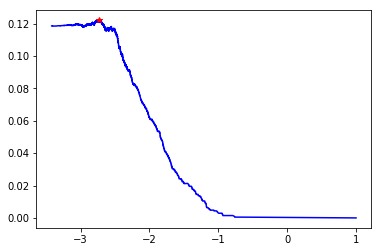

{'threshold': -2.729013442993164, 'f1': 0.12208289794496689}

In [34]:
thr = threshold_search(all_actual, preddd, plot=True);thr

In [ ]:
thr['threshold']

def train_model(model, train_data, epochs, show=False):
    
    #optimizer = torch.optim.Adam(model.parameters())
    optimizer = optim.SGD(model.parameters(), lr=0.0001)
    #loss_function = nn.BCEWithLogitsLoss(reduction='mean')
    loss_function = nn.NLLLoss()
    
    print("The loss function being used is {}".format(loss_function))
    errors = []
    eval_errors = []
    f1_train = []
    auc_train = []
    f1_eval = []
    auc_eval = []
    
    num_training_batches = len(train_data)
    
    for epoch in range(epochs):
        print("Epoch {}".format(epoch + 1))
        print("Training mode")
        model.train()
        train_iter = iter(train_data)
        model.zero_grad()
        train_loss = 0
        all_preds = []
        all_actual = []
        for batch_num in range(num_training_batches):
            print("Batch {}".format(batch_num + 1))
            print("Out of {}".format(num_training_batches))
            batch = next(train_iter)
            text, class_vector = batch.question_text.transpose(0,1),batch.target.unsqueeze(1)
            #print(batch)
            #print(text.shape)
            #optimizer.zero_grad()
            text_pred = model(text)
            #print(text_pred)
            print(class_vector.shape)
            print(torch.max(class_vector,1)[0].shape)
            loss = loss_function(text_pred,class_vector.reshape(64,1).squeeze(1)) #torch.max(class_vector,1)[0])
            print(loss)
            print(text_pred.squeeze(1))
            print(torch.max(class_vector,1)[0])
            loss.backward()
            optimizer.step()
    

    
    

In [ ]:
#train_iters = iter(train_iter)

In [ ]:
#wee = next(train_iters)

In [ ]:
#wee.question_text.shape